In [1]:
import fsspec
import cf_xarray
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import xoak

# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo='s3://nextgen-dmac-cloud-ingest/nos/creofs/nos.creofs.fields.best.nc.zarr', remote_protocol='s3', remote_options={'anon':True}, target_protocol='s3', target_options={'anon':True})
m = fs.get_mapper("") 

ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={})
ds

<xarray.Dataset>
Dimensions:      (time: 49, sigma: 37, node: 74061, nface: 3, nele: 142684,
                  nv: 54, nz: 17)
Coordinates:
    lat          (node) float32 dask.array<chunksize=(74061,), meta=np.ndarray>
    lon          (node) float32 dask.array<chunksize=(74061,), meta=np.ndarray>
  * sigma        (sigma) float32 -1.0 -0.9722 -0.9444 ... -0.05556 -0.02778 0.0
  * time         (time) datetime64[ns] 2023-10-26T15:00:00 ... 2023-10-28T15:...
Dimensions without coordinates: node, nface, nele, nv, nz
Data variables: (12/18)
    Cs           (time, sigma) float32 dask.array<chunksize=(1, 37), meta=np.ndarray>
    Pair         (time, node) float32 dask.array<chunksize=(1, 74061), meta=np.ndarray>
    ele          (time, nface, nele) int32 dask.array<chunksize=(1, 3, 142684), meta=np.ndarray>
    h            (time, node) float32 dask.array<chunksize=(1, 74061), meta=np.ndarray>
    offset       (time, node) float32 dask.array<chunksize=(1, 74061), meta=np.ndarray>
    salinity     (time, nv, node) float32 dask.array<chunksize=(1, 54, 74061), meta=np.ndarray>
    ...           ...
    x            (time, node) float32 dask.array<chunksize=(1, 74061), meta=np.ndarray>
    y            (time, node) float32 dask.array<chunksize=(1, 74061), meta=np.ndarray>
    z            (time, nz) float32 dask.array<chunksize=(1, 17), meta=np.ndarray>
    zeta         (time, node) float32 dask.array<chunksize=(1, 74061), meta=np.ndarray>
    zeta_adj     (time, node) float32 dask.array<chunksize=(1, 74061), meta=np.ndarray>
    zval         (time, nv, node) float32 dask.array<chunksize=(1, 54, 74061), meta=np.ndarray>
Attributes:
    Vertical_type:    Hybrid SZ vertical coordinates, K=1 for bottom
    grid_type:        Unstructured model grid:
    history:          Created at Eastern Local Time 16:25  10/26/2023
    model_developer:  Oregon Health & Science University
    model_link:       http://www.ccalmr.ogi.edu/CORIE/modeling/selfe
    reference:        Created by CO-OPS/NOS/NOAA
    source:           SELFE-MPI Version 3.1dc
    title:            Columbia River & Estuarine Operational Forecast System
    type:             gridded/field NetCDF file - CF-1.0

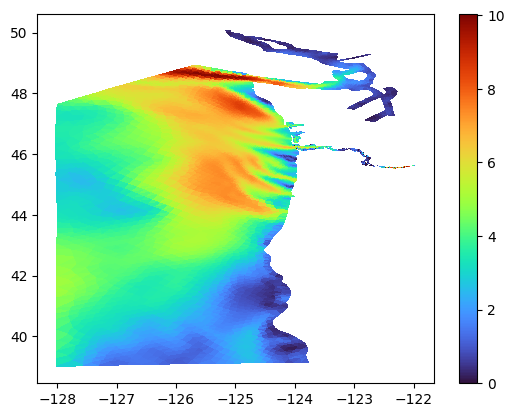

In [33]:
u_wind = ds.uwind_speed.cf.isel(time=2)
v_wind = ds.vwind_speed.cf.isel(time=2)
wind = np.sqrt(u_wind**2 + v_wind**2)
nv = ds.ele.isel(time=2).T - 1
tris = tri.Triangulation(wind.cf['longitude'], wind.cf['latitude'], triangles=nv)
plt.tripcolor(tris, wind.fillna(0).values, cmap='turbo')
plt.colorbar()

To get the surface temperature, we need to find the sigma index closest to the surface, then subset the temperature at that index. Then we can plot the nodes

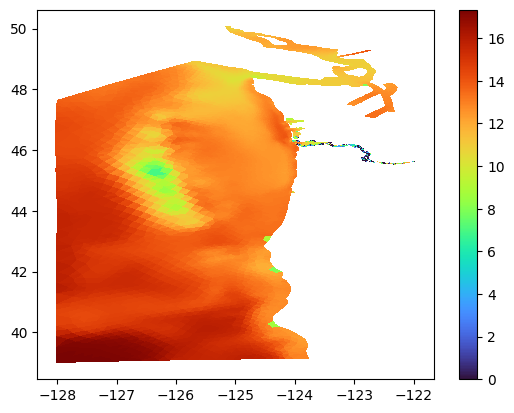

In [14]:
sigma_index = int(abs(ds.sigma).argmin(dim='sigma').values)
temp = ds.temp.isel(nv=sigma_index).cf.isel(time=2)
nv = ds.ele.isel(time=2).T - 1
tris = tri.Triangulation(temp.cf['longitude'], temp.cf['latitude'], triangles=nv)
plt.tripcolor(tris, temp.fillna(0).values, cmap='turbo')
plt.colorbar()

We can xoak to get data from a specific latitude and longitude

In [28]:
ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
selection = ds.xoak.sel(lat=xr.DataArray([40, ]), lon=xr.DataArray([-127.0,]))
temp = selection.temp.cf.isel(time=slice(1, 10)).isel(nv=sigma_index)

CPU times: user 1.26 s, sys: 469 ms, total: 1.73 s
Wall time: 12.5 s


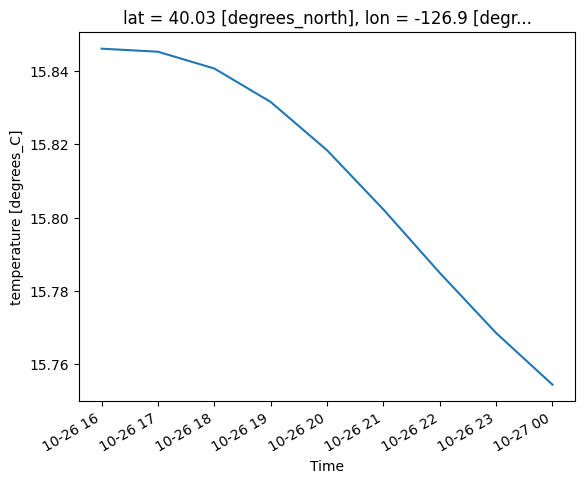

In [26]:
%%time

temp.plot()